## Astronomy 406 "Computational Astrophysics" (Fall 2017)

### Week 12: Machine Learning methods for Classification

<b>Reading:</b> notes below, as well as $\S$9.3-9.7 of [Machine Learning](http://www.astroml.org/).

Last week we looked at [Gaussian Mixture](http://scikit-learn.org/stable/modules/mixture.html) modeling. It can be used to assign data points to distinct and separate classes.  Sklearn module provides several others methods for classification:

[Nearest Neighbors](http://scikit-learn.org/stable/modules/neighbors.html)

[Support Vector Machines](http://scikit-learn.org/stable/modules/svm.html)

[Random Forest](http://scikit-learn.org/stable/modules/ensemble.html#forest)

Comparison of different classification methods is [here](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

We will use examples provided by ML.<br>
Gaussian classifier:
[Figure 9.1](http://www.astroml.org/book_figures/chapter9/fig_bayes_DB.html) and
[Figure 9.2](http://www.astroml.org/book_figures/chapter9/fig_simple_naivebayes.html)<br>
SVM classifier:
[Figure 9.9](http://www.astroml.org/book_figures/chapter9/fig_svm_diagram.html)

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

### Mixture Modeling

In [2]:
feh, m, d = np.loadtxt('DataFiles/gc.dat', unpack=True)
logd = np.log10(d)
X = np.vstack([feh, logd]).T

best fit converged: True
BIC: N components = 2


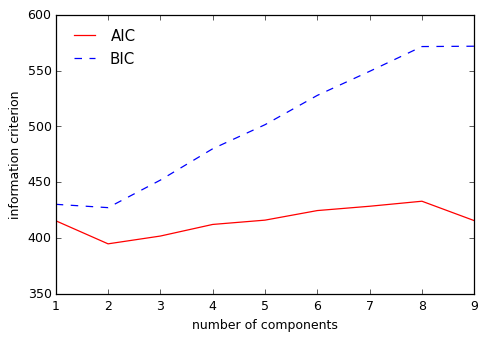

In [3]:
from sklearn.mixture import GMM

N = np.arange(1, 10)
models = [None for n in N]

for i in range(len(N)):
    models[i] = GMM(N[i], covariance_type='full').fit(X)
#Can force circular fit if covariance type is spherical instead of full
    
    
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print 'best fit converged:', gmm_best.converged_
#print 'number of interations =', gmm_best.n_iter_   #Answer is 5...
print 'BIC: N components = %i' % N[i_best]

plt.plot(N, AIC, 'r-', label='AIC')
plt.plot(N, BIC, 'b--', label='BIC')
plt.xlabel('number of components')
plt.ylabel('information criterion')
plt.legend(loc=2, frameon=False)
plt.show()

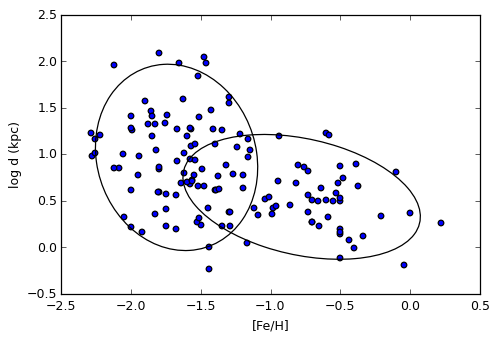

In [4]:
from astroML.plotting.tools import draw_ellipse

plt.scatter(feh, logd)
plt.xlabel('[Fe/H]')
plt.ylabel('log d (kpc)')

for mu, C, w in zip(gmm_best.means_, gmm_best.covars_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[2], fc='none', ec='k')

Download a dataset of galaxies with spectroscopic information from the SDSS survey.

In [5]:
from astroML.datasets import fetch_sdss_specgals
from astroML.plotting import scatter_contour

data = fetch_sdss_specgals()
print data.shape, 'spectra fields:', data.dtype.names

(661598L,) spectra fields: ('ra', 'dec', 'mjd', 'plate', 'fiberID', 'z', 'zErr', 'rChi2', 'velDisp', 'velDispErr', 'extinction_r', 'petroMag_r', 'psfMag_r', 'psfMagErr_r', 'modelMag_u', 'modelMagErr_u', 'modelMag_g', 'modelMagErr_g', 'modelMag_r', 'modelMagErr_r', 'modelMag_i', 'modelMagErr_i', 'modelMag_z', 'modelMagErr_z', 'petroR50_r', 'petroR90_r', 'nii_6584_flux', 'nii_6584_flux_err', 'h_alpha_flux', 'h_alpha_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err', 'h_beta_flux', 'h_beta_flux_err', 'h_delta_flux', 'h_delta_flux_err', 'd4000', 'd4000_err', 'bptclass', 'lgm_tot_p50', 'sfr_tot_p50', 'objID', 'specObjID')


114527 galaxies selected


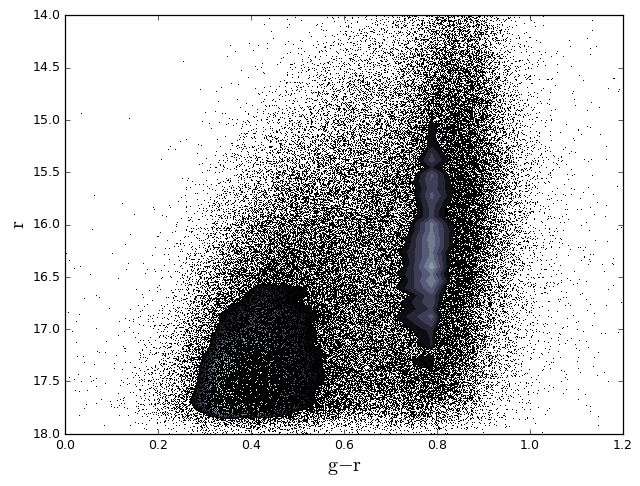

In [6]:
# redshift cut 0.02 < z < 0.06
data = data[data['z'] > 0.02]
data = data[data['z'] < 0.06]

gr = data['modelMag_g'] - data['modelMag_r']
r = data['modelMag_r']
print len(r), 'galaxies selected'

'''
fig, ax = plt.subplots(figsize=(8, 6))
scatter_contour(r, gr, threshold=400, log_counts=True, ax=ax,
                histogram2d_args=dict(bins=100),
                plot_args=dict(marker=',', linestyle='none', color='black'),
                contour_args=dict(cmap=plt.cm.bone))

ax.set_xlabel(r'${\rm r}$', size=16)
ax.set_ylabel(r'${\rm g - r}$', size=16)
'''
fig, ax = plt.subplots(figsize=(8, 6))
scatter_contour(gr, r, threshold=400, log_counts=True, ax=ax,
                histogram2d_args=dict(bins=100),
                plot_args=dict(marker=',', linestyle='none', color='black'),
                contour_args=dict(cmap=plt.cm.bone))

ax.set_ylabel(r'${\rm r}$', size=16)
ax.set_xlabel(r'${\rm g - r}$', size=16)

ax.set_ylim(18, 14)
ax.set_xlim(0, 1.2)
plt.show()

There is a bimodality in the color distribution.

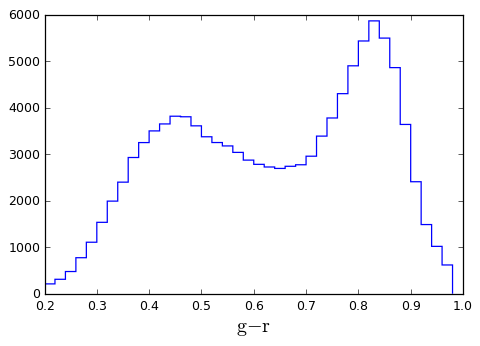

In [7]:
plt.hist(gr, bins=np.arange(0.2,1,0.02), histtype='step')
#plt.hist(gr[:100], bins=np.arange(0.2,1,0.02), histtype='step')
plt.xlabel(r'${\rm g - r}$', size=16)

Select the training set and the test set.  Let's take 1000 points in each.

In [8]:
X = np.vstack([r, gr]).T
print 'total dataset:', X.shape, 'galaxies'

Xtraining = X[:100]
print 'training set:', len(Xtraining), 'galaxies'

Xtest = X[-1000:]
print 'test set:', len(Xtest), 'galaxies'

# set targets
border = 0.65
target = (Xtraining[:,1] > border)
target_test = (Xtest[:,1] > border)

total dataset: (114527L, 2L) galaxies
training set: 100 galaxies
test set: 1000 galaxies


best fit converged: True
BIC: N components = 1


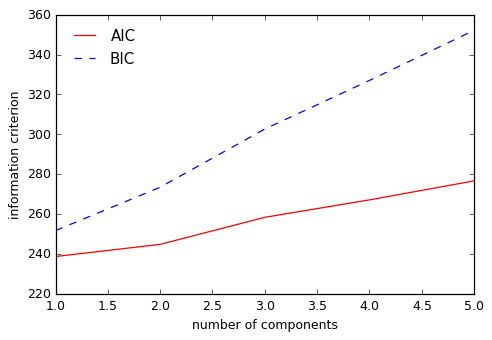

In [9]:
N = np.arange(1, 6)
models = [None for n in N]

for i in range(len(N)):
    models[i] = GMM(N[i], covariance_type='full').fit(X)

AIC = [m.aic(Xtraining) for m in models]
BIC = [m.bic(Xtraining) for m in models]

i_best = np.argmin(AIC)
gmm_best = models[i_best]
print 'best fit converged:', gmm_best.converged_
#print 'number of interations =', gmm_best.n_iter_
print 'BIC: N components = %i' % N[i_best]

plt.plot(N, AIC, 'r-', label='AIC')
plt.plot(N, BIC, 'b--', label='BIC')
plt.xlabel('number of components')
plt.ylabel('information criterion')
plt.legend(loc=2, frameon=False)
plt.show()

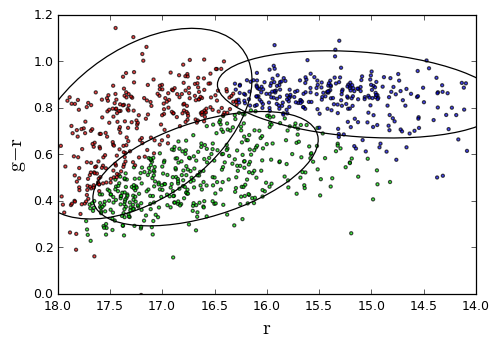

In [10]:
cmap_bold = ListedColormap(['#00FF00', '#FF0000', '#0000FF'])

#plt.scatter(Xtraining[:,1], Xtraining[:,0], cmap=cmap_bold, alpha=0.7, s=6)
#plt.xlim(18,14)
#plt.ylim(0,1.2)
#plt.xlabel(r'${\rm r}$', size=16)
#plt.ylabel(r'${\rm g - r}$', size=16)

clf = models[2]
clf.fit(Xtraining)
y = clf.predict(Xtest)

#y = clf.predict(Xtraining)   #y is like the target
#plt.scatter(Xtraining[:,0], Xtraining[:,1], c=y, cmap=cmap_bold, alpha=0.7, s=6)

#y = clf.predict(Xtest)   #y is like the target
plt.scatter(Xtest[:,0], Xtest[:,1], c=y, cmap=cmap_bold, alpha=0.7, s=6)

plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)

gmm_best = models[2]
for mu, C, w in zip(gmm_best.means_, gmm_best.covars_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[2], fc='none', ec='k')

[]

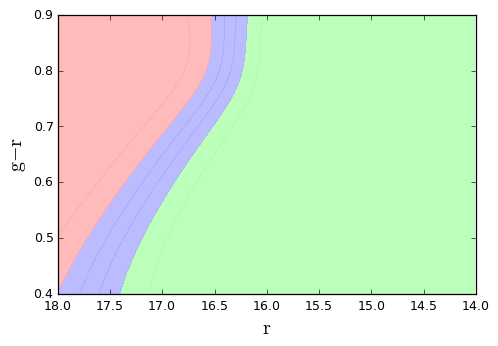

In [11]:
xx, yy = np.meshgrid(np.arange(18,14,-0.02), np.arange(0,1.2,0.02))

#Explains decision_function, predict_proba
#https://stackoverflow.com/questions/36543137/whats-the-difference-between-predict-proba-and-decision-function-in-sklearn-py

if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]   #Predict probability for point x and y

Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#AAFFAA', '#AAAAFF', '#FFAAAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.contourf(xx, yy, Z, alpha=.8, cmap=cmap_light)
plt.xlim(18,14)
plt.ylim(0.4,0.9)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

## Nearest Neighbors

# Test what happens if you change n_neighbors, weights (to uniform), and clf.fit to apply to Xtest as your training set

[]

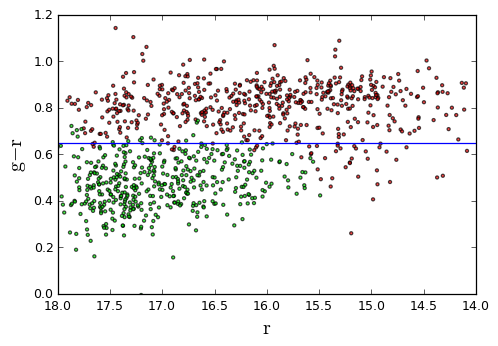

In [12]:
clf = neighbors.KNeighborsClassifier(n_neighbors=4, weights='distance')

# evaluate fit 
clf.fit(Xtraining, target)
#clf.fit(Xtest,target_test)

# apply fit to the remaining test data
y = clf.predict(Xtest)   #y is like the target
#If we input xtraining, we would get target, but we don't know what it is for xtest

cmap_bold = ListedColormap(['#00FF00', '#FF0000'])
plt.scatter(Xtest[:,0], Xtest[:,1], c=y, cmap=cmap_bold, alpha=0.7, s=6)
plt.axhline(border)
plt.xlim(18,14)
plt.ylim(0,1.2)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

Close-up view near the decision boundary.

[]

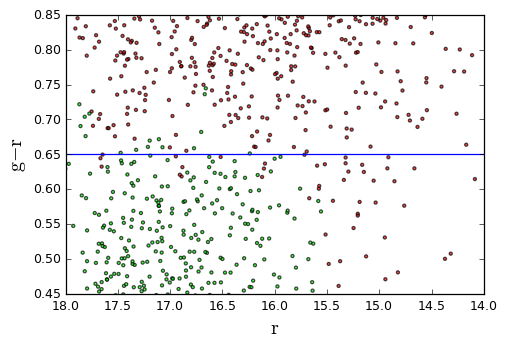

In [13]:
plt.scatter(Xtest[:,0], Xtest[:,1], c=y, cmap=cmap_bold, alpha=0.7, s=6)
plt.axhline(border)
plt.xlim(18,14)
plt.ylim(0.45,0.85)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()

[]

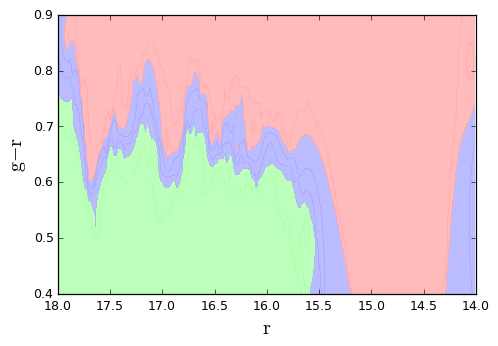

In [14]:
xx, yy = np.meshgrid(np.arange(18,14,-0.02), np.arange(0,1.2,0.02))

#Explains decision_function, predict_proba
#https://stackoverflow.com/questions/36543137/whats-the-difference-between-predict-proba-and-decision-function-in-sklearn-py

if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]   #Predict probability for point x and y

Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#AAFFAA', '#AAAAFF', '#FFAAAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
plt.contourf(xx, yy, Z, alpha=.8, cmap=cmap_light)
plt.xlim(18,14)
plt.ylim(0.4,0.9)
plt.xlabel(r'${\rm r}$', size=16)
plt.ylabel(r'${\rm g - r}$', size=16)
plt.plot()